In [171]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit, prange

In [172]:
colors = ["#7fc97f","#beaed4","#fdc086","#fbfb5e","#386cb0","#e84ca0"]

In [173]:
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi']=200
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

## Random walks without self avoidance

### Computing the possible moves

In [174]:
Verbose = False
# Possible next moves without self avoidance
def possible_moves_ideal(position, last_position, dim=2):
    moves = []
    for d in range(dim):
        for step in [-1, 1]:
            new_position = position[:d] + (position[d] + step,) + position[d+1:]
            if new_position != last_position:
                moves.append(new_position)
    return moves

# Possible next moves with self avoidance
def possible_moves_sa(position, visited, dim=2):
    moves = []
    for d in range(dim):
        for step in [-1, 1]:
            new_position = position[:d] + (position[d] + step,) + position[d+1:]
            if new_position not in visited:
                moves.append(new_position)
    return moves




### Functions to characterize the polimers

In [175]:
# End to end lenght
def end_to_end_length(walk):
    start = np.array(walk[0])
    end = np.array(walk[-1])
    return np.linalg.norm(end - start)

# Center of mass
def center_of_mass(walk):
    positions = np.array(walk)
    return np.mean(positions, axis=0)

# Radius of gyration
def radius_of_gyration(walk):
    com = center_of_mass(walk)
    positions = np.array(walk)
    diffs = positions - com
    sq_dists = np.sum(diffs**2, axis=1)
    return np.sqrt(np.mean(sq_dists))

def compute_walk_metrics(walk):
    """Compute all metrics for a single walk."""
    positions = np.asarray(walk)
    
    # End-to-end distance
    diff = positions[-1] - positions[0]
    R_p2 = np.dot(diff, diff)
    
    # Center of mass
    com = positions.mean(axis=0)
    
    # Radius of gyration
    sq_dists = np.sum((positions - com)**2, axis=1)
    R_g2 = sq_dists.mean()
    
    return R_p2, R_g2

### Generating the walks, while keeping trak of the parameters

In [176]:
# Random walk without self avoidance, returns statistical weight of the walk, traks metrics at all steps
def random_walk(steps, dim=2, track_metrics=False):
    position = tuple([0]*dim)
    walk = [position]
    last_position = None
    w = 1
    visited = {position}
    
    # Pre-allocate arrays for metric tracking
    if track_metrics:
        weights = np.zeros(steps + 1)
        Rp2_lengths = np.zeros(steps + 1)
        Rg2_values = np.zeros(steps + 1)
        weights[0] = w
        Rp2_lengths[0] = 0.0
        Rg2_values[0] = 0.0
        
        # Convert walk to array incrementally
        positions = np.zeros((steps + 1, dim))
        positions[0] = position
        
    for i in range(steps):
        moves = possible_moves_ideal(position, last_position, dim)

        
        if Verbose:
            print(f"Possible moves: {moves}, m: {m}")
        
        position = moves[np.random.randint(len(moves))]
        walk.append(position)
        visited.add(position)
        last_position = position
        w *= 1
        
        if track_metrics:
            step_idx = i + 1
            weights[step_idx] = w
            
            # Compute metrics incrementally (only up to current step)
            R_p2, R_g2 = compute_walk_metrics(walk)
            Rp2_lengths[step_idx] = R_p2
            Rg2_values[step_idx] = R_g2
    
    if track_metrics:
        return walk, {
            'weights': weights,
            'e2e_lengths': Rp2_lengths,
            'rg_values': Rg2_values,
            'final_weight': w
        }
    return walk, w


def self_avoiding_walk(steps, dim=2, max_retries=1000, track_metrics=False):
    for attempt in range(max_retries):
        position = tuple([0]*dim)
        walk = [position]
        visited = {position}
        w = 1
        
        # Pre-allocate arrays for metric tracking
        if track_metrics:
            weights = np.zeros(steps + 1)
            Rp2_lengths = np.zeros(steps + 1)
            Rg2_values = np.zeros(steps + 1)
            weights[0] = w
            Rp2_lengths[0] = 0.0
            Rg2_values[0] = 0.0
            positions = np.zeros((steps + 1, dim))
            positions[0] = position
        
        success = True
        for i in range(steps):
            moves = possible_moves_sa(position, visited, dim)
            m = len(moves)
            
            if m == 0:
                success = False
                break
            
            if Verbose:
                print(f"Possible moves: {moves}, m: {m}")
            
            position = moves[np.random.randint(m)]
            walk.append(position)
            visited.add(position)
            w *= m
            
            if track_metrics:
                step_idx = i + 1
                weights[step_idx] = w
                
                # Compute metrics incrementally (only up to current step)
                R_p2, R_g2 = compute_walk_metrics(walk)
                Rp2_lengths[step_idx] = R_p2
                Rg2_values[step_idx] = R_g2
        
        if success:
            if track_metrics:
                return walk, {
                    'weights': weights,
                    'e2e_lengths': Rp2_lengths,
                    'rg_values': Rg2_values,
                    'final_weight': w
                }
            return walk, w
    
    raise RuntimeError(f"Failed to generate self-avoiding walk after {max_retries} attempts")

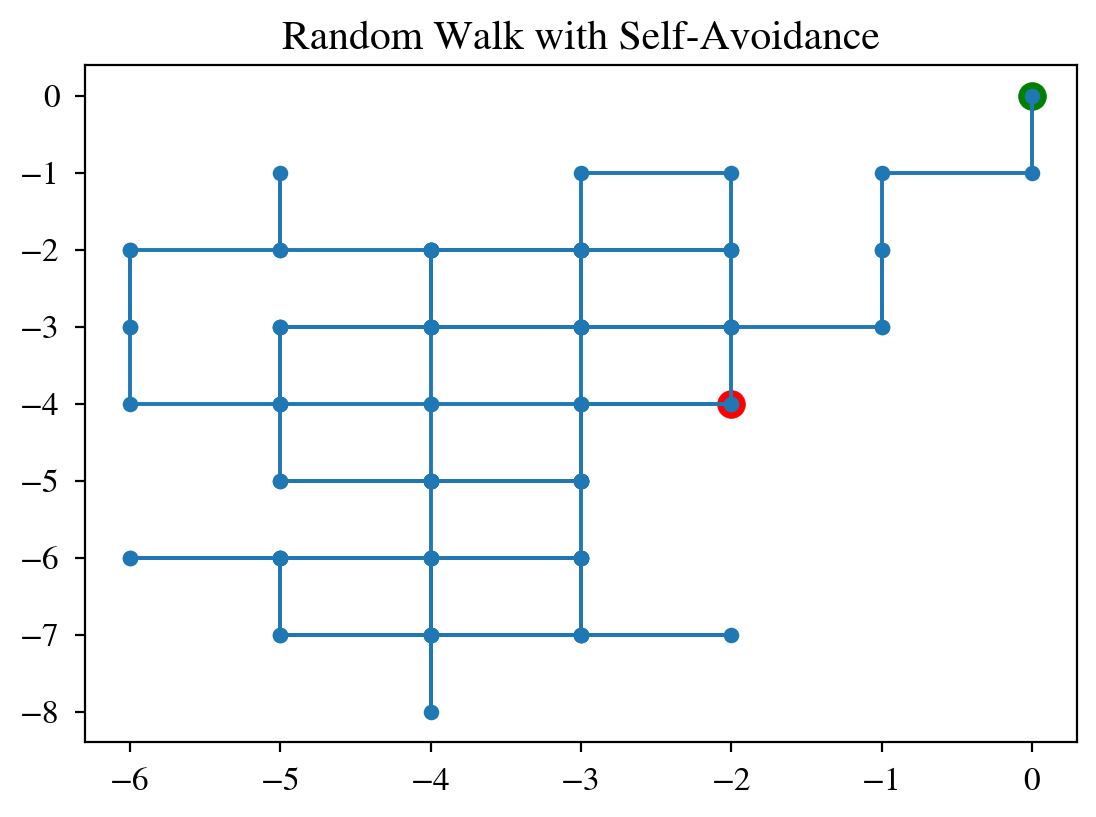

In [177]:
Verbose = False
r , w= random_walk(100, dim=2)
x,y= zip(*r)

plt.plot(x,y, marker='o')
plt.title("Random Walk with Self-Avoidance")
plt.scatter(x[0], y[0], c='green', s=100)  # Start
plt.scatter(x[-1], y[-1], c='red', s=100)  # End
plt.show()

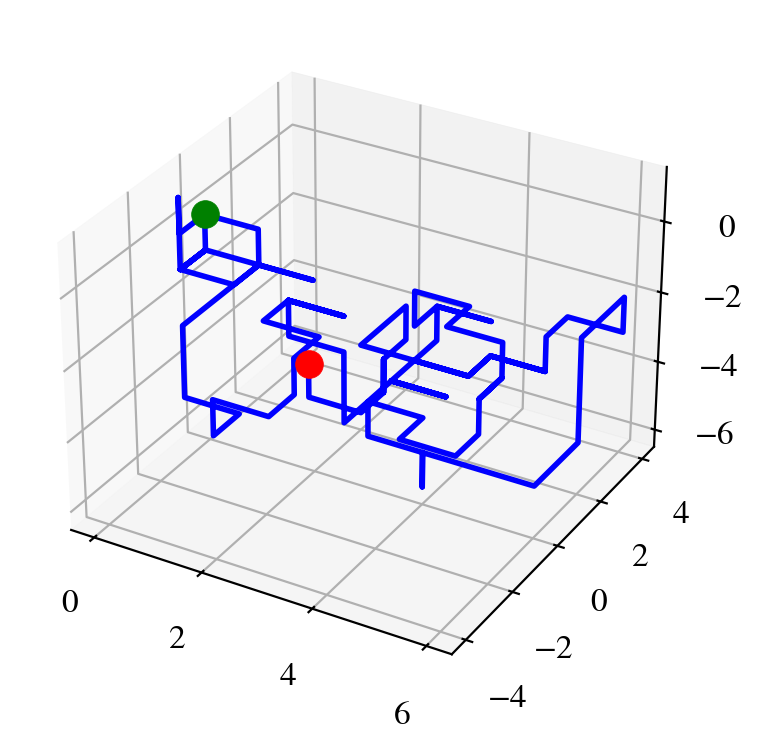

In [178]:
r , w= random_walk(100, dim=3)
# Extract coordinates
x, y, z = zip(*r)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'b-', linewidth=2)
ax.scatter(x[0], y[0], z[0], c='green', s=100)  # Start
ax.scatter(x[-1], y[-1], z[-1], c='red', s=100)  # End
plt.show()

### Simulating an ensamble of M polimers

In [179]:
# Batch simulation: Generate M polymers and average metrics at each length
def simulate_ensemble(num_polymers, max_N, dim=2, self_avoiding=True, rosenbluth=False):
    """
    Generate M polymers of length N and extract metrics for all lengths <= N.
    
    Returns averaged metrics across ensemble for each polymer length.
    """
    # Accumulate weighted metrics
    sum_e2e_squared = np.zeros(max_N + 1)
    sum_rg_squared = np.zeros(max_N + 1)
    sum_weights = np.zeros(max_N + 1)
    
    walk_func = self_avoiding_walk if self_avoiding else random_walk
    
    for _ in range(num_polymers):
        walk, metrics = walk_func(max_N, dim=dim, track_metrics=True)
        weights = metrics['weights']
        e2e = metrics['e2e_lengths']
        rg = metrics['rg_values']
        
        if rosenbluth:
            # Accumulate weighted statistics
            sum_weights += weights
            sum_e2e_squared += weights * e2e
            sum_rg_squared += weights * rg
        else:
            # Uniform weight
            sum_weights += 1
            sum_e2e_squared += e2e
            sum_rg_squared += rg
    
    # Compute weighted averages
    # Avoid division by zero
    valid = sum_weights > 0
    mean_e2e_squared = np.zeros_like(sum_e2e_squared)
    mean_rg_squared = np.zeros_like(sum_rg_squared)
    
    mean_e2e_squared[valid] = sum_e2e_squared[valid] / sum_weights[valid]
    mean_rg_squared[valid] = sum_rg_squared[valid] / sum_weights[valid]
    
    return {
        'lengths': np.arange(max_N + 1),
        'mean_e2e_squared': mean_e2e_squared,
        'mean_rg_squared': mean_rg_squared,
        'mean_e2e': np.sqrt(mean_e2e_squared),
        'mean_rg': np.sqrt(mean_rg_squared),
        'total_weight': sum_weights,
        'num_polymers': num_polymers
    }

## Exercise, part A. Ideal polymer

a) Calculate the dependence of $R_P^2$ and $R_g^2$ on the number of monomers for $N<N_{max}=100$. Plot your results.

b) Extract the exponent $\nu$

In [103]:
dict_metrics2d = simulate_ensemble(num_polymers=10000, max_N=100, dim=2, self_avoiding=False)
dict_metrics3d = simulate_ensemble(num_polymers=10000, max_N=100, dim=3, self_avoiding=False)


Fit power laws to the data

In [221]:

import scipy.optimize
def power_law(x, a, b):
    return a * x**(2*b)

def fit_power_law(N, R2):
    popt, pcov = scipy.optimize.curve_fit(power_law, N[1:], R2[1:])
    print(f"Fitted R ~ N^2*{popt[1]:.3f}")
    
    nu = popt[1]
    # a = popt[0]
    error = np.sqrt(np.diag(pcov))[1] / 2
    print(f"Extracted nu: {nu:.4f} ± {error:.4f}")
    return nu , error
# dict_metrics = simulate_ensemble(num_polymers=1000, max_N=100, dim=2, self_avoiding=False)
N_values = dict_metrics2d['lengths']
radious_p2d = dict_metrics2d['mean_e2e_squared']
radious_g2d = dict_metrics2d['mean_rg_squared']
radious_p3d = dict_metrics3d['mean_e2e_squared']
radious_g3d = dict_metrics3d['mean_rg_squared']
nup2d , _ = fit_power_law(N_values, radious_p2d)
nug2d , _ = fit_power_law(N_values, radious_g2d)
nup3d , _ = fit_power_law(N_values, radious_p3d)
nug2d , _ = fit_power_law(N_values, radious_g3d)

Fitted R ~ N^2*0.502
Extracted nu: 0.5024 ± 0.0002
Fitted R ~ N^2*0.492
Extracted nu: 0.4923 ± 0.0002
Fitted R ~ N^2*0.499
Extracted nu: 0.4992 ± 0.0002
Fitted R ~ N^2*0.491
Extracted nu: 0.4906 ± 0.0002


In [ ]:
# Prepare to plot fitting power laws
# Hard coded fits, I'm sorry. But the exponents are well calculated
x_fit = np.linspace(1, 100, 100)
y_fit_p2d = power_law(x_fit, 1, nup2d)
y_fit_g2d = power_law(x_fit, 0.183, nug2d)

y_fit_p3d = power_law(x_fit, 1, nup3d)
y_fit_g3d = power_law(x_fit, 0.183, nug2d)

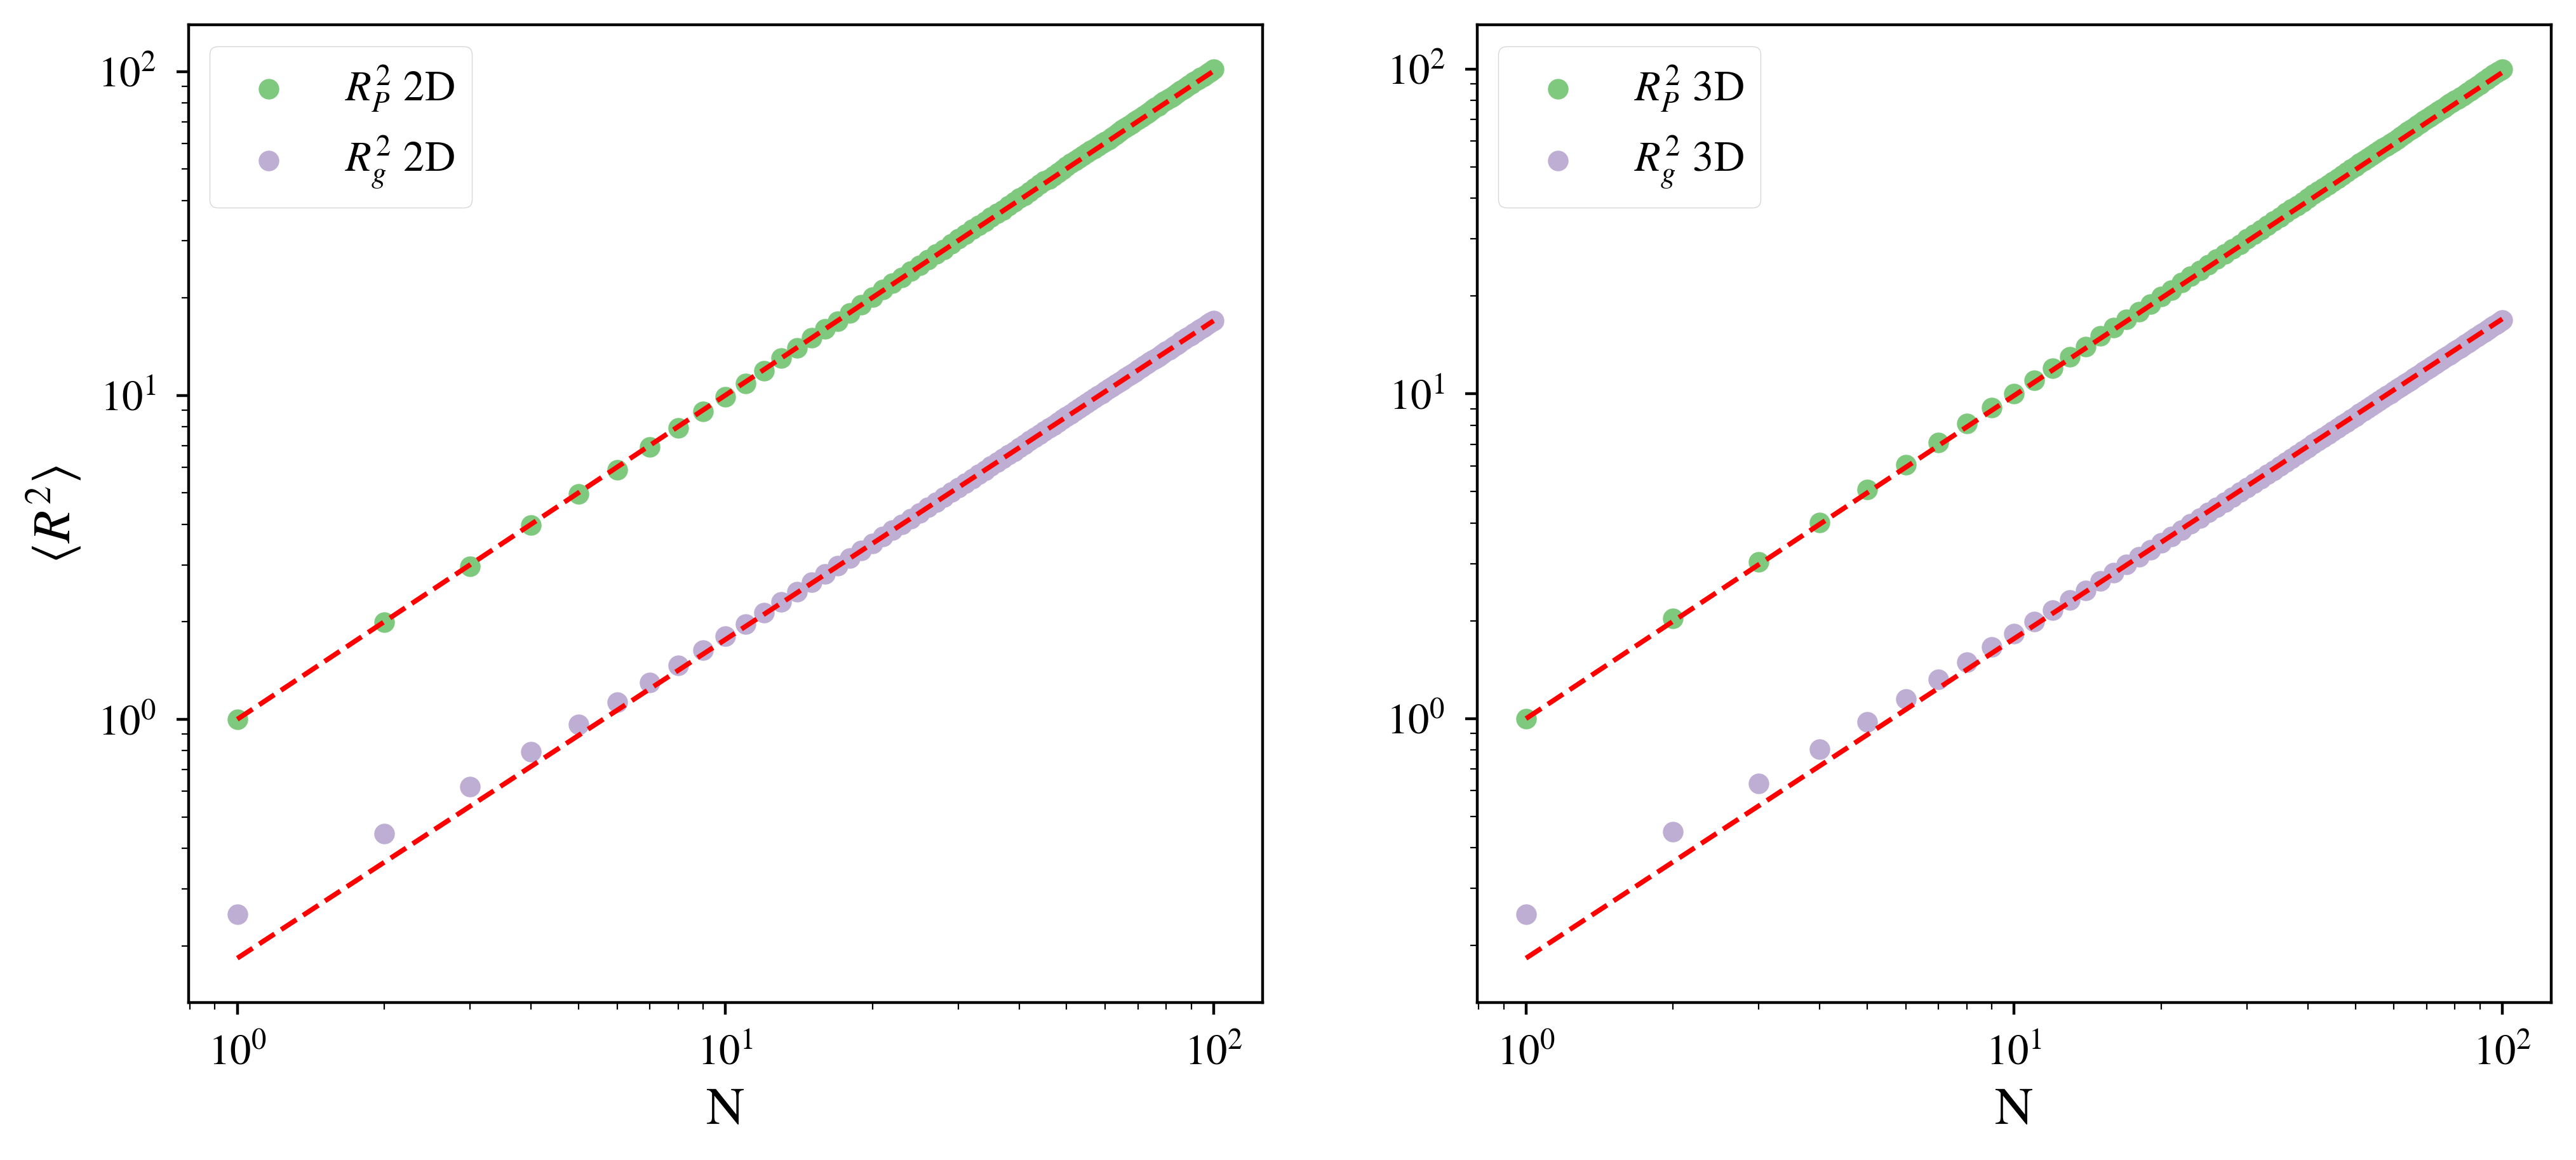

In [146]:
# Plotting the results
plt.rcParams['figure.dpi']=400

N_values = dict_metrics2d['lengths']
radious_p2d = dict_metrics2d['mean_e2e_squared']
radious_g2d = dict_metrics2d['mean_rg_squared']
radious_p3d = dict_metrics3d['mean_e2e_squared']
radious_g3d = dict_metrics3d['mean_rg_squared']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(N_values, radious_p2d, c=colors[0],label=r"$R_P^2$ 2D")
plt.scatter(N_values, radious_g2d, c=colors[1],label=r"$R_g^2$ 2D")
plt.plot(x_fit, y_fit_p2d, 'r--')
plt.plot(x_fit, y_fit_g2d, 'r--')
plt.xlabel("N")
plt.ylabel(r"$\langle R^2 \rangle$")
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(N_values, radious_p3d, c=colors[0], label=r"$R_P^2$ 3D")
plt.scatter(N_values, radious_g3d, c=colors[1],label=r"$R_g^2$ 3D")
plt.plot(x_fit, y_fit_p3d, 'r--')
plt.plot(x_fit, y_fit_g3d, 'r--')
plt.xlabel("N")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Part B, excluded volume polymer.

a) Calculate the dependence of $R_P^2$ and $R_g^2$ on the number of monomers for $N<N_{max}=100$. Do the averages: (i) using bare averages; (ii) using the Rosenbluth sampling method.

b) Represent  $R_P^2$ and $R_g^2$ vs $N$ for the two averaging methods. Show on a log-log plot.

c) Extract the exponent $\nu$.

In [181]:
# 2D self avoiding polimer bare average vs Rosembluth sampling
dict_metrics = simulate_ensemble(num_polymers=10000, max_N=100, dim=2, self_avoiding=True)
dict_metricsR = simulate_ensemble(num_polymers=10000, max_N=100, dim=2, self_avoiding=True, rosenbluth=True)

In [222]:
# Extract exponents
N_values = dict_metrics['lengths']
radious_p = dict_metrics['mean_e2e_squared']
radious_g = dict_metrics['mean_rg_squared']
radious_pR = dict_metricsR['mean_e2e_squared']
radious_gR = dict_metricsR['mean_rg_squared']
nup2d , _ = fit_power_law(N_values, radious_p)
nug2d , _ = fit_power_law(N_values, radious_g)
nup2dR , _ = fit_power_law(N_values, radious_pR)
nug2dR , _ = fit_power_law(N_values, radious_gR)

Fitted R ~ N^2*0.643
Extracted nu: 0.6430 ± 0.0016
Fitted R ~ N^2*0.652
Extracted nu: 0.6522 ± 0.0005
Fitted R ~ N^2*0.753
Extracted nu: 0.7533 ± 0.0044
Fitted R ~ N^2*0.776
Extracted nu: 0.7758 ± 0.0020


In [223]:
# Prepare to plot fitting power laws
# Hard coded fits, I'm sorry. But the exponents are well calculated
x_fit = np.linspace(1, 100, 100)
y_fit_p2d = power_law(x_fit, 1.15, nup2d)
y_fit_p2dR = power_law(x_fit, 0.85, nup2dR)

y_fit_g2d = power_law(x_fit, 0.159, nug2d)
y_fit_g2dR = power_law(x_fit, 0.095, nug2dR)

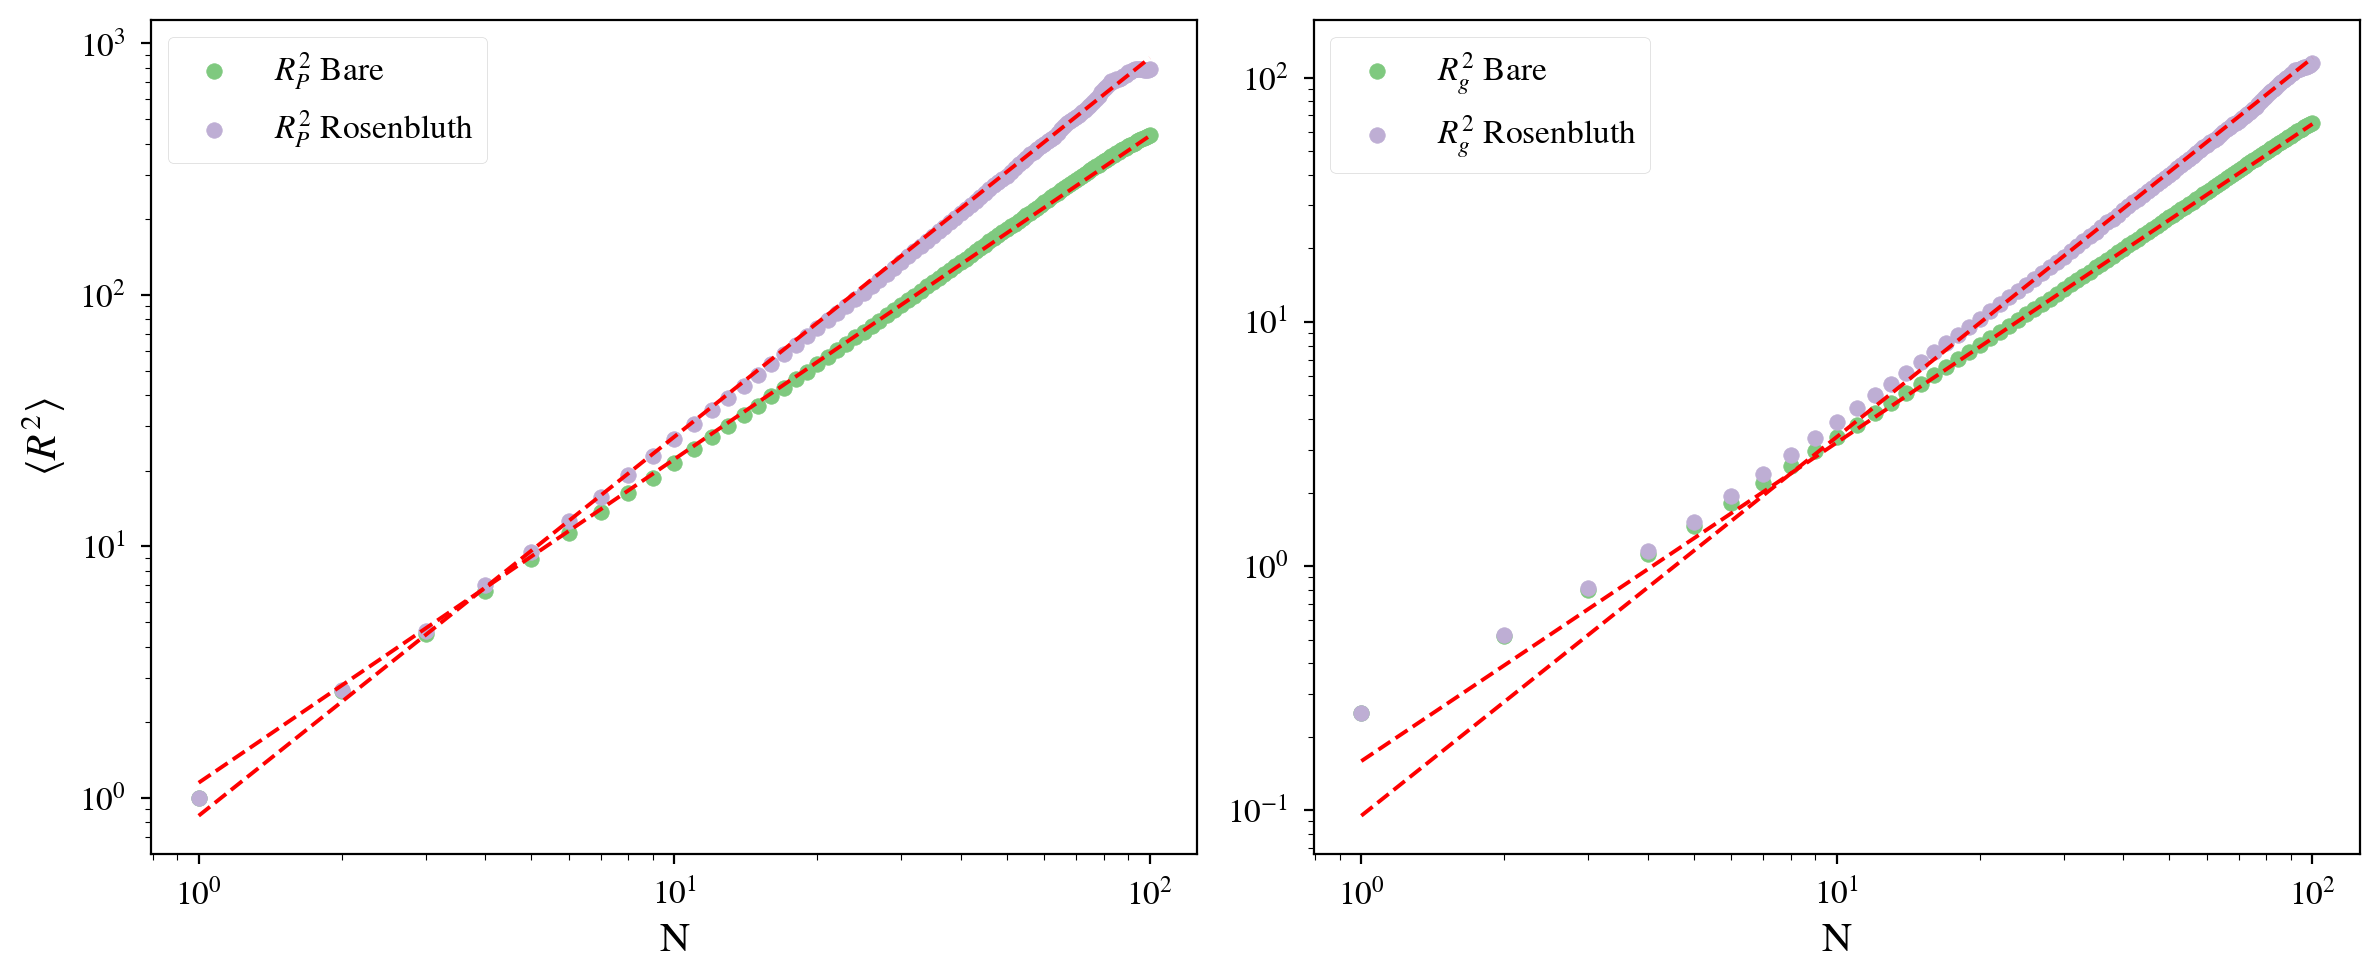

In [226]:

# Plotting the results
N_values = dict_metrics['lengths']
radious_p = dict_metrics['mean_e2e_squared']
radious_g = dict_metrics['mean_rg_squared']
radious_pR = dict_metricsR['mean_e2e_squared']
radious_gR = dict_metricsR['mean_rg_squared']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(N_values, radious_p, c=colors[0],label=r"$R_P^2$ Bare")
plt.scatter(N_values, radious_pR, c=colors[1],label=r"$R_P^2$ Rosenbluth")
plt.plot(x_fit, y_fit_p2d, 'r--')
plt.plot(x_fit, y_fit_p2dR, 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")
plt.ylabel(r"$\langle R^2 \rangle$")
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(N_values, radious_g,c=colors[0], label=r"$R_g^2$ Bare")
plt.scatter(N_values, radious_gR,c=colors[1], label=r"$R_g^2$ Rosenbluth")
plt.plot(x_fit, y_fit_g2d, 'r--')
plt.plot(x_fit, y_fit_g2dR, 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")

plt.tight_layout()
plt.legend()
plt.show()

Self avoiding, dimension 3

In [227]:
# 3D self avoiding polimer bare average vs Rosembluth sampling
dict_metrics = simulate_ensemble(num_polymers=10000, max_N=100, dim=3, self_avoiding=True)
dict_metricsR = simulate_ensemble(num_polymers=10000, max_N=100, dim=3, self_avoiding=True, rosenbluth=True)

In [228]:
# Extract exponents
N_values = dict_metrics['lengths']
radious_p = dict_metrics['mean_e2e_squared']
radious_g = dict_metrics['mean_rg_squared']
radious_pR = dict_metricsR['mean_e2e_squared']
radious_gR = dict_metricsR['mean_rg_squared']
nup2d , _ = fit_power_law(N_values, radious_p)
nug2d , _ = fit_power_law(N_values, radious_g)
nup2dR , _ = fit_power_law(N_values, radious_pR)
nug2dR , _ = fit_power_law(N_values, radious_gR)

Fitted R ~ N^2*0.523
Extracted nu: 0.5228 ± 0.0004
Fitted R ~ N^2*0.526
Extracted nu: 0.5263 ± 0.0001
Fitted R ~ N^2*0.609
Extracted nu: 0.6095 ± 0.0010
Fitted R ~ N^2*0.612
Extracted nu: 0.6117 ± 0.0007


In [254]:
# Prepare to plot fitting power laws
# Hard coded fits, I'm sorry. But the exponents are well calculated
x_fit = np.linspace(1, 100, 100)
y_fit_p2d = power_law(x_fit, 1.45, nup2d)
y_fit_p2dR = power_law(x_fit, 1, nup2dR)

y_fit_g2d = power_law(x_fit, 0.23, nug2d)
y_fit_g2dR = power_law(x_fit, 0.158, nug2dR)

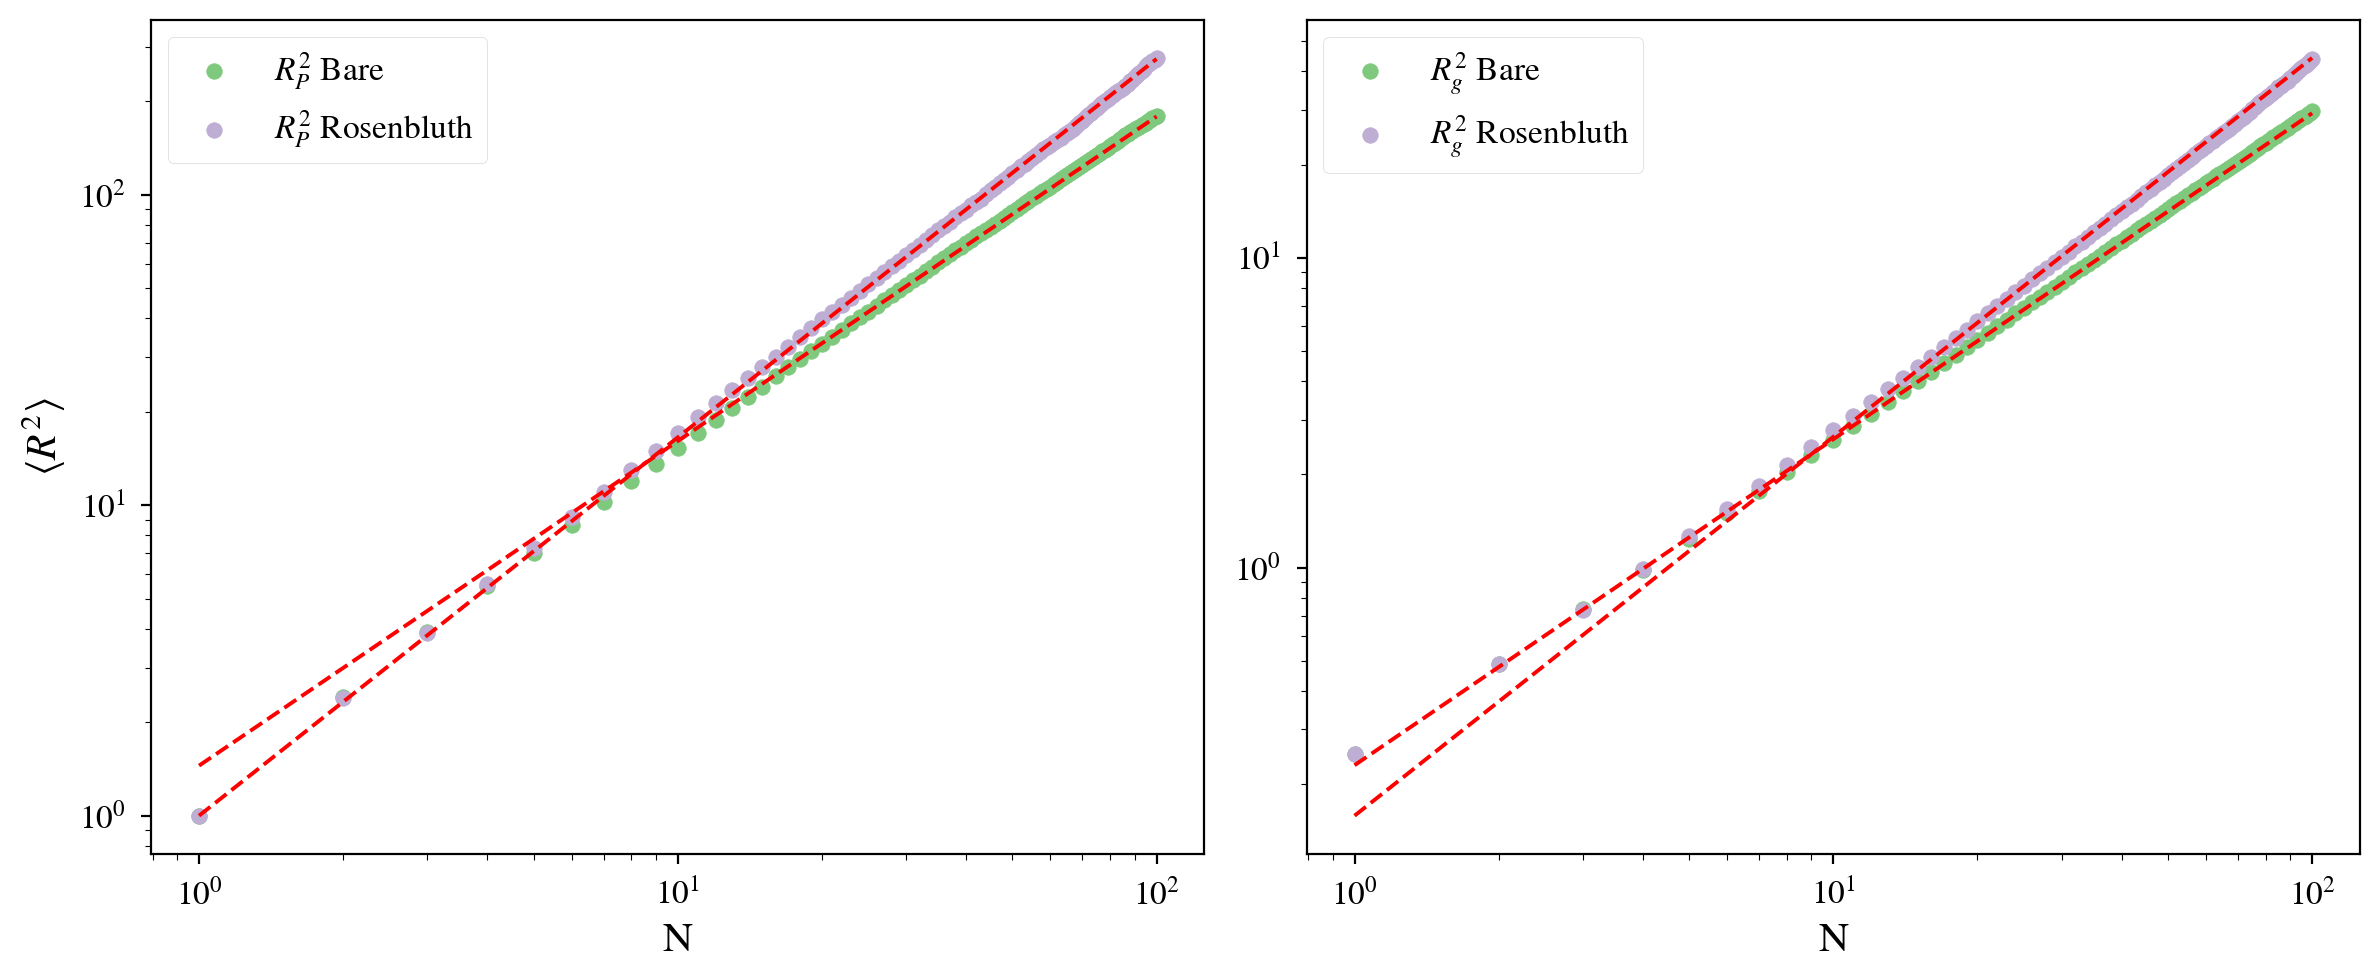

In [255]:
# Plotting the results
N_values = dict_metrics['lengths']
radious_p = dict_metrics['mean_e2e_squared']
radious_g = dict_metrics['mean_rg_squared']
radious_pR = dict_metricsR['mean_e2e_squared']
radious_gR = dict_metricsR['mean_rg_squared']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(N_values, radious_p, c=colors[0], label=r"$R_P^2$ Bare")
plt.scatter(N_values, radious_pR, c=colors[1], label=r"$R_P^2$ Rosenbluth")
plt.plot(x_fit, y_fit_p2d, 'r--')
plt.plot(x_fit, y_fit_p2dR, 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")
plt.ylabel(r"$\langle R^2 \rangle$")
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(N_values, radious_g, c=colors[0],  label=r"$R_g^2$ Bare")
plt.scatter(N_values, radious_gR, c=colors[1], label=r"$R_g^2$ Rosenbluth")
plt.plot(x_fit, y_fit_g2d, 'r--')
plt.plot(x_fit, y_fit_g2dR, 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")

plt.tight_layout()
plt.legend()
plt.show()

In [238]:
# Extract exponents
fit_power_law(N_values, radious_p)
fit_power_law(N_values, radious_g)
fit_power_law(N_values, radious_pR)
fit_power_law(N_values, radious_gR)

Fitted R ~ N^2*0.523
Extracted nu: 0.5228 ± 0.0004
Fitted R ~ N^2*0.526
Extracted nu: 0.5263 ± 0.0001
Fitted R ~ N^2*0.609
Extracted nu: 0.6095 ± 0.0010
Fitted R ~ N^2*0.612
Extracted nu: 0.6117 ± 0.0007


(0.6116724081354485, 0.0007109239379916726)